# CasADi demo

## What is CasADi?

 * A tool for quick & efficient implementation of algorithms for dynamic optimization
 * Open source, LGPL-licensed,    <a href="http://casadi.org">casadi.org</a>
 * C++ / C++11
 * Interfaces to Python, Haskell, (Matlab?)
 * Numerical backends: <a href="https://projects.coin-or.org/Ipopt">IPOPT</a>, <a href="http://computation.llnl.gov/casc/sundials/main.html">Sundials</a>, ...
 * Developers in group of Moritz Diehl:
   * Joel Andersson
   * Joris Gillis
   * Greg Horn

## Outline of demo

 * Scalar expression (SX) graphs
 * Functions of SX graphs
 * Matrices of scalar expressions
 * Automatic differentiation (AD)
 * Integrators
 * Matrix expression (MX) graphs
 * Functions of MX graphs
 * Solving an optimal control problem

## Scalar expression (SX) graphs

In [1]:
from __future__ import print_function
from pylab import *
from casadi import *
from casadi.tools import *  # for dotdraw
from IPython.display import Image, display
%matplotlib inline

def view_dot(graph):
   plt = Image(graph.create_png())
   display(plt)

In [2]:
x = SX.sym("x")  # scalar symbolic primitives
y = SX.sym("y")

z = x*sin(x+y)   # common mathematical operators

In [3]:
print(z)

(x*sin((x+y)))


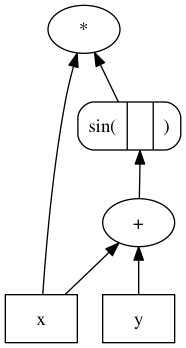

In [4]:
view_dot(dotgraph(z,direction="BT"))

In [5]:
J = jacobian(z,x)
print(J)

@1=(x+y), (sin(@1)+(x*cos(@1)))


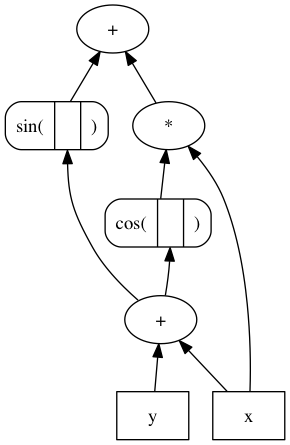

In [6]:
view_dot(dotgraph(J,direction="BT"))

> Note 1: subexpressions are shared.
>
>   Graph $\leftrightarrow$ Tree
>   
>  Different from Maple, Matlab symbolic, sympy, ...

A (very) little bit of Computer Algebra

In [7]:
print(x*y/x-y)

0


In [8]:
H = hessian(z,x)
print(H)

(SX(@1=(x+y), (cos(@1)+(cos(@1)-(x*sin(@1))))), SX(@1=(x+y), (sin(@1)+(cos(@1)*x))))


## Functions of SX graphs

Sort graph into algorithm

In [9]:
f = Function("f",[x,y],[z])

f.disp(True)

f:(i0,i1)->(o0) SXFunction
Algorithm:
@0 = input[0][0];
@1 = input[1][0];
@1 = (@0+@1);
@1 = sin(@1);
@0 = (@0*@1);
output[0][0] = @0;

> Note 2: re-use of tape variables: live-variables

In [10]:
print(f(1.2,3.4))

-1.19243


In [11]:
print(f(1.2,x+y))

@1=1.2, (@1*sin((@1+(x+y))))


In [12]:
f.generate("f")
print(open("f.c").read())

/* This file was automatically generated by CasADi.
   The CasADi copyright holders make no ownership claim of its contents. */
#ifdef __cplusplus
extern "C" {
#endif

/* How to prefix internal symbols */
#ifdef CODEGEN_PREFIX
  #define NAMESPACE_CONCAT(NS, ID) _NAMESPACE_CONCAT(NS, ID)
  #define _NAMESPACE_CONCAT(NS, ID) NS ## ID
  #define CASADI_PREFIX(ID) NAMESPACE_CONCAT(CODEGEN_PREFIX, ID)
#else
  #define CASADI_PREFIX(ID) f_ ## ID
#endif

#include <math.h>

#ifndef casadi_real
#define casadi_real double
#endif

#ifndef casadi_int
#define casadi_int long long int
#endif

/* Add prefix to internal symbols */
#define casadi_f0 CASADI_PREFIX(f0)
#define casadi_s0 CASADI_PREFIX(s0)

/* Symbol visibility in DLLs */
#ifndef CASADI_SYMBOL_EXPORT
  #if defined(_WIN32) || defined(__WIN32__) || defined(__CYGWIN__)
    #if defined(STATIC_LINKED)
      #define CASADI_SYMBOL_EXPORT
    #else
      #define CASADI_SYMBOL_EXPORT __declspec(dllexport)
    #endif
  #elif defined(__GNUC__) && define

## Matrices of scalar expressions

In [13]:
A = SX.sym("A",3,3)
B = SX.sym("B",3)
print(A)


[[A_0, A_3, A_6], 
 [A_1, A_4, A_7], 
 [A_2, A_5, A_8]]


In [14]:
print(solve(A,B))

@1=(((A_0*((A_4*A_8)-(A_7*A_5)))-(A_3*((A_1*A_8)-(A_7*A_2))))+(A_6*((A_1*A_5)-(A_4*A_2)))), [((((((A_4*A_8)-(A_7*A_5))/@1)*B_0)-((((A_3*A_8)-(A_6*A_5))/@1)*B_1))+((((A_3*A_7)-(A_6*A_4))/@1)*B_2)), ((((((A_0*A_8)-(A_6*A_2))/@1)*B_1)-((((A_1*A_8)-(A_7*A_2))/@1)*B_0))-((((A_0*A_7)-(A_6*A_1))/@1)*B_2)), ((((((A_1*A_5)-(A_4*A_2))/@1)*B_0)-((((A_0*A_5)-(A_3*A_2))/@1)*B_1))+((((A_0*A_4)-(A_3*A_1))/@1)*B_2))]


In [15]:
print(trace(A))   # Trace

((A_0+A_4)+A_8)


In [16]:
print(mtimes(A,B))   # Matrix multiplication
#print(A @ B)        # Matrix multiplication in Python3

[(((A_0*B_0)+(A_3*B_1))+(A_6*B_2)), (((A_1*B_0)+(A_4*B_1))+(A_7*B_2)), (((A_2*B_0)+(A_5*B_1))+(A_8*B_2))]


In [17]:
print(norm_fro(A))  # Frobenius norm

sqrt(((((((((sq(A_0)+sq(A_1))+sq(A_2))+sq(A_3))+sq(A_4))+sq(A_5))+sq(A_6))+sq(A_7))+sq(A_8)))


In [18]:
print(A[2,:])     # Slicing

[[A_2, A_5, A_8]]


> Rule 1: Everything is a matrix

In [19]:
print(A.shape, z.shape)

(3, 3) (1, 1)


In [20]:
I = SX.eye(3)
print(I)

@1=1, 
[[@1, 00, 00], 
 [00, @1, 00], 
 [00, 00, @1]]


In [21]:
Ak = kron(I,A)
print(Ak)


[[A_0, A_3, A_6, 00, 00, 00, 00, 00, 00], 
 [A_1, A_4, A_7, 00, 00, 00, 00, 00, 00], 
 [A_2, A_5, A_8, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, A_0, A_3, A_6, 00, 00, 00], 
 [00, 00, 00, A_1, A_4, A_7, 00, 00, 00], 
 [00, 00, 00, A_2, A_5, A_8, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, A_0, A_3, A_6], 
 [00, 00, 00, 00, 00, 00, A_1, A_4, A_7], 
 [00, 00, 00, 00, 00, 00, A_2, A_5, A_8]]


> Rule 1: Everything is a sparse matrix

In [22]:
Ak.sparsity().spy()

***......
***......
***......
...***...
...***...
...***...
......***
......***
......***


In [23]:
A.sparsity().spy()

***
***
***


In [24]:
z.sparsity().spy()

*


## Automatic differentiation (AD)

Consider an ode:

\begin{equation}
\dot{p} = (1 - q^2)p-q+u
\end{equation}
\begin{equation}
\dot{q} = p
\end{equation}
\begin{equation}
\dot{c} = p^2+q^2+u^2
\end{equation}

In [25]:
t = SX.sym("t")    # time
u = SX.sym("u")    # control
p = SX.sym("p")
q = SX.sym("q")
c = SX.sym("c")
x = vertcat(p,q,c) # state

In [26]:
ode = vertcat((1 - q**2)*p - q + u, p, p**2+q**2+u**2)
print(ode, ode.shape)

[((((1-sq(q))*p)-q)+u), p, ((sq(p)+sq(q))+sq(u))] (3, 1)


In [27]:
J = jacobian(ode,x)
print(J)

@1=1, 
[[(@1-sq(q)), (-1-(p*(q+q))), 00], 
 [@1, 00, 00], 
 [(p+p), (q+q), 00]]


In [28]:
f = Function("f",[t,u,x],[ode])

ffwd = f.forward(1)

fadj = f.reverse(1)

# side-by-side printing
print('{:*^24} || {:*^28} || {:*^28}'.format("f","ffwd","fadj"))
def short(f):
    import re
    return re.sub(r", a\.k\.a\. \"(\w+)\"",r". \1",f.str(True).replace(", No description available","").replace("Input ","").replace("Output ",""))
for l in zip(short(f).split("\n"),short(ffwd).split("\n"),short(fadj).split("\n")):
  print('{:<24} || {:<28} || {:<28}'.format(*l))

***********f************ || ************ffwd************ || ************fadj************
f:(i0,i1,i2[3])->(o0[3]) SXFunction || fwd1_f:(i0,i1,i2[3],out_o0[3x1,0nz],fwd_i0,fwd_i1,fwd_i2[3])->(fwd_o0[3]) SXFunction || adj1_f:(i0,i1,i2[3],out_o0[3x1,0nz],adj_o0[3])->(adj_i0,adj_i1,adj_i2[3]) SXFunction
Algorithm:               || Algorithm:                   || Algorithm:                  
@0 = 1;                  || @0 = 1;                      || @0 = 0;                     
@1 = input[2][1];        || @1 = input[2][1];            || output[0][0] = @0;          
@2 = sq(@1);             || @2 = sq(@1);                 || @1 = input[1][0];           
@0 = (@0-@2);            || @0 = (@0-@2);                || @1 = (@1+@1);               
@2 = input[2][0];        || @2 = input[6][0];            || @2 = input[4][2];           
@0 = (@0*@2);            || @0 = (@0*@2);                || @1 = (@1*@2);               
@0 = (@0-@1);            || @3 = input[2][0];            || @3 = input[4][0]

Performing **forward sweeps** gives the **columns** of J

In [29]:
print(I)

@1=1, 
[[@1, 00, 00], 
 [00, @1, 00], 
 [00, 00, @1]]


In [30]:
for i in range(3):
  print(ffwd(t,u,x, ode, 0,0,I[:,i]))

@1=1, [(@1-sq(q)), @1, (p+p)]
[(-((p*(q+q))+1)), 0, (q+q)]
@1=0, [@1, @1, @1]


In [31]:
print(J)

@1=1, 
[[(@1-sq(q)), (-1-(p*(q+q))), 00], 
 [@1, 00, 00], 
 [(p+p), (q+q), 00]]


Performing **adjoint sweeps** gives the **rows** of J

In [32]:
for i in range(3):
  print(fadj(t,u,x, ode, I[:,i])[2])

[(1-sq(q)), (-1-((q+q)*p)), 0]
@1=0, [1, @1, @1]
[(p+p), (q+q), 0]


Often, you can do better than slicing with unit vectors

> Note 3: CasADi does graph coloring for efficient sparse jacobians

## Integrators

$\dot{x}=f(x,u,t)$ with $x = [p,q,c]^T$

In [33]:
f = {'x':x,'t':t,'p':u,'ode':ode}

Construct an integrating block $x_{k+1} = \Phi(f;\Delta t;x_k,u_k)$

In [34]:
tf = 10.0
N = 20
dt = tf/N

In [35]:
Phi = integrator("Phi","cvodes",f,{"tf":dt})

x0 = DM([0,1,0])

print(Phi(x0=x0))

{'qf': DM([]), 'rqf': DM([]), 'rxf': DM([]), 'rzf': DM([]), 'xf': DM([-0.494019, 0.876097, 0.500982]), 'zf': DM([])}


In [36]:
x = x0
xs = [x]

for i in range(N):
  x = Phi(x0=x)["xf"]
  
  xs.append(x)

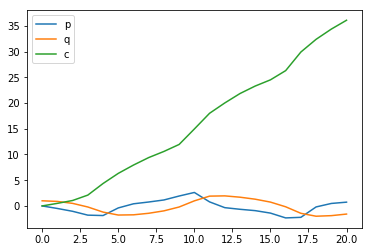

In [37]:
plot(horzcat(*xs).T)
legend(["p","q","c"])

> Rule 2: Everything is a Function  (see http://docs.casadi.org)

## Matrix expression (MX) graphs

> Note 4: this is what makes CasADi stand out among AD tools

Recall


[[(((A_0*B_0)+(A_3*B_1))+(A_6*B_2)), (((A_0*B_3)+(A_3*B_4))+(A_6*B_5)), (((A_0*B_6)+(A_3*B_7))+(A_6*B_8))], 
 [(((A_1*B_0)+(A_4*B_1))+(A_7*B_2)), (((A_1*B_3)+(A_4*B_4))+(A_7*B_5)), (((A_1*B_6)+(A_4*B_7))+(A_7*B_8))], 
 [(((A_2*B_0)+(A_5*B_1))+(A_8*B_2)), (((A_2*B_3)+(A_5*B_4))+(A_8*B_5)), (((A_2*B_6)+(A_5*B_7))+(A_8*B_8))]]


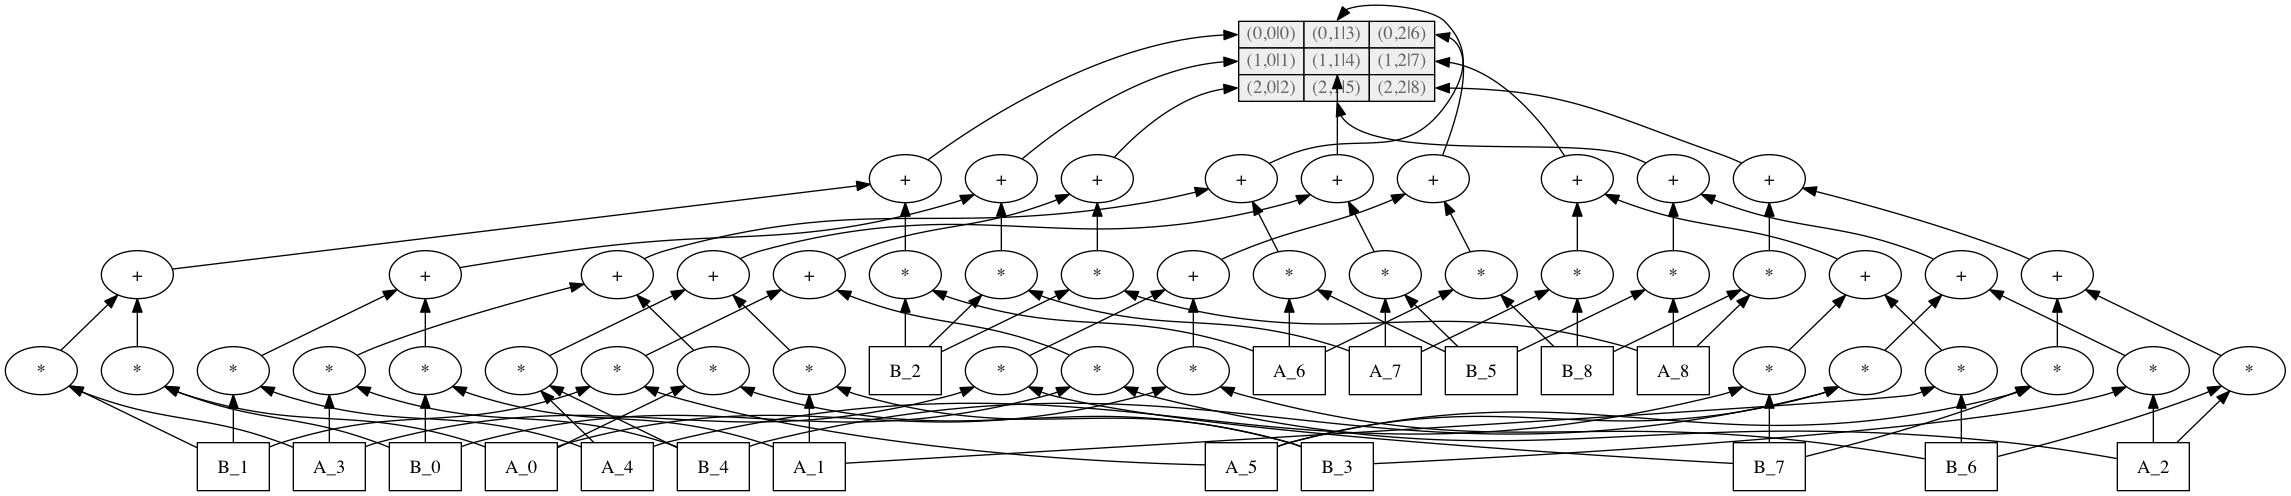

In [38]:
n = 3

A = SX.sym("A",n,n)
B = SX.sym("B",n,n)
C = mtimes(A,B)
print(C)
view_dot(dotgraph(C,direction='BT'))

What if you **don't want** to expand into scalar operations?  ( avoid $O(n^3)$ storage)

mac(A,B,zeros(3x3))


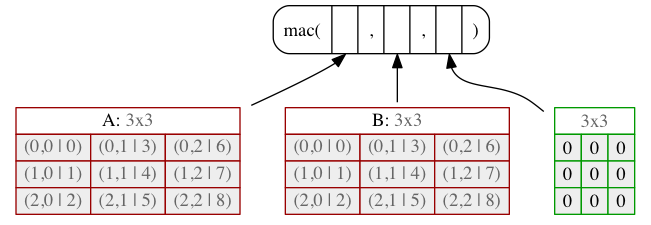

In [39]:
A = MX.sym("A",n,n)
B = MX.sym("B",n,n)
C = mtimes(A,B)
print(C)
view_dot(dotgraph(C,direction='BT'))

What if you **cannot** expand into matrix operations?  ( numerical algorithm )

(A\B)


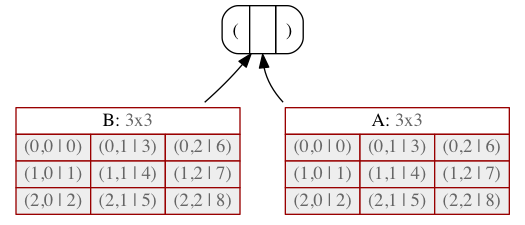

In [40]:
C = solve(A,B)
print(C)
view_dot(dotgraph(C,direction='BT'))

In [41]:
X0 = MX.sym("x",3)

XF = Phi(x0=X0)["xf"]
print(XF)

Phi(x, 0, 0x1, 0x1, 0x1, 0x1){0}


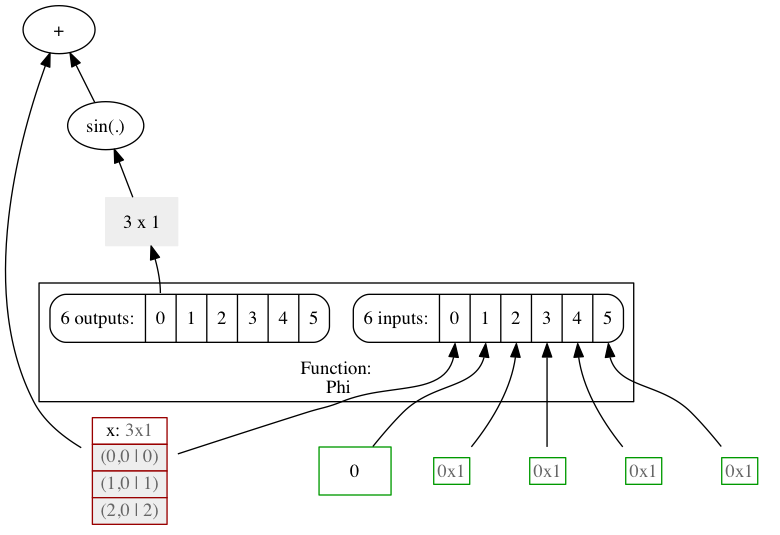

In [42]:
expr = sin(XF)+X0
view_dot(dotgraph(expr,direction='BT'))

## Functions of MX graphs

In [43]:
F = Function("F",[X0],[  expr  ])
print(F)

F:(i0[3])->(o0[3]) MXFunction


In [44]:
print(F(x0))

[-0.474168, 1.76825, 0.480287]


In [45]:
J = Function("J",[X0],[  jacobian(expr,X0)  ])

print(J(x0))


[[1.87245, -0.239128, 00], 
 [0.316248, 1.5856, 00], 
 [-0.0101749, 0.861809, 1.87711]]


This shows how an integrator-call can be embedded in matrix graph.

More possibilities:  external compiled library, a call to Matlab/Scipy

## Solving an optimal control problem

\begin{equation}
\begin{array}{cl}
\underset{p(.),q(.),u(.)}{\text{minimize}}  & \displaystyle \int_{0}^{T}{ p(t)^2 + q(t)^2 + u(t)^2 dt} \\\\
\text{subject to}
& \dot{p} = (1 - q^2)p-q+u   \\\\
& \dot{q} = p \\\\
& p(0) = 0, q(0) = 1 \\\\
&-1 \le u(t) \le 1
\end{array}
\end{equation}



Remember, $\dot{x}=f(x,u,t)$ with $x = [p,q,c]^T$

\begin{equation}
\begin{array}{cl}
\underset{x(.),u(.)}{\text{minimize}}  & c(T) \\\\
\text{subject to}
& \dot{x} = f(x,u) \\\\
& p(0) = 0, q(0) = 1, c(0)= 0 \\\\
&-1 \le u(t) \le 1
\end{array}
\end{equation}

Discretization with multiple shooting

\begin{equation}
\begin{array}{cl}
\underset{x_{\bullet},u_{\bullet}}{\text{minimize}}  & c_N \\\\
\text{subject to}
& x_{k+1} - \Phi(x_k,u_k) = 0 , \quad \quad k = 0,1,\ldots, (N-1) \\\\
& p_0 = 0, q_0 = 1, c_0 = 0 \\\\
&-1 \le u_k \le 1  , \quad \quad k = 0,1,\ldots, (N-1) 
\end{array}
\end{equation}

Cast as NLP

\begin{equation}
\begin{array}{cl}
\underset{X}{\text{minimize}}  & F(X,P) \\\\
\text{subject to}
& \text{lbx} \le X \le \text{ubx} \\\\
& \text{lbg} \le G(X,P) \le \text{ubg} \\\\
\end{array}
\end{equation}

In [46]:
X = struct_symMX([
     (
      entry("x", repeat=N+1, struct=struct(["p","q","c"]) ),
      entry("u", repeat=N)
     )
    ])

X is a symbolic matrix primitive, but with fancier indexing

In [47]:
print(X.shape)
print((N+1)*3+N)

(83, 1)
83


Demo: $\Phi(x_0,u_0)$

In [48]:
Xf = Phi( x0=X["x",0],p=X["u",0] )["xf"]

print(Xf)

@1=vertsplit(V), Phi(@1{0}, @1{1}, 0x1, 0x1, 0x1, 0x1){0}


$ x_{k+1} - \Phi(x_k,u_k) = 0 , \quad \quad k = 0,1,\ldots, (N-1)$

In [49]:
g = [] # List of constraint expressions

for k in range(N):
  Xf = Phi( x0=X["x",k],p=X["u",k] )["xf"]
  g.append( X["x",k+1]-Xf )

In [50]:
obj = X["x",N,"c"] # c_N

nlp = {"x":X, "g": vcat(g), "f": obj}

print(nlp)

{'x': <casadi.tools.structure3.msymStruct object at 0x114149c50>, 'g': MX(@1=vertsplit(V), @2=@1{2}, @3=@1{4}, @4=@1{6}, @5=@1{8}, @6=@1{10}, @7=@1{12}, @8=@1{14}, @9=@1{16}, @10=@1{18}, @11=@1{20}, @12=@1{22}, @13=@1{24}, @14=@1{26}, @15=@1{28}, @16=@1{30}, @17=@1{32}, @18=@1{34}, @19=@1{36}, @20=@1{38}, vertcat((@2-Phi(@1{0}, @1{1}, 0x1, 0x1, 0x1, 0x1){0}), (@3-Phi(@2, @1{3}, 0x1, 0x1, 0x1, 0x1){0}), (@4-Phi(@3, @1{5}, 0x1, 0x1, 0x1, 0x1){0}), (@5-Phi(@4, @1{7}, 0x1, 0x1, 0x1, 0x1){0}), (@6-Phi(@5, @1{9}, 0x1, 0x1, 0x1, 0x1){0}), (@7-Phi(@6, @1{11}, 0x1, 0x1, 0x1, 0x1){0}), (@8-Phi(@7, @1{13}, 0x1, 0x1, 0x1, 0x1){0}), (@9-Phi(@8, @1{15}, 0x1, 0x1, 0x1, 0x1){0}), (@10-Phi(@9, @1{17}, 0x1, 0x1, 0x1, 0x1){0}), (@11-Phi(@10, @1{19}, 0x1, 0x1, 0x1, 0x1){0}), (@12-Phi(@11, @1{21}, 0x1, 0x1, 0x1, 0x1){0}), (@13-Phi(@12, @1{23}, 0x1, 0x1, 0x1, 0x1){0}), (@14-Phi(@13, @1{25}, 0x1, 0x1, 0x1, 0x1){0}), (@15-Phi(@14, @1{27}, 0x1, 0x1, 0x1, 0x1){0}), (@16-Phi(@15, @1{29}, 0x1, 0x1, 0x1, 0x1){0}),

Block structure in the constraint Jacobian

In [51]:
jacG = jacobian(nlp["g"],nlp["x"])

S = jacG.sparsity()

print(S.shape)

DM.ones(S)[:20,:20].sparsity().spy()

(60, 83)
**.**...............
**.*.*..............
****..*.............
....**.**...........
....**.*.*..........
....****..*.........
........**.**.......
........**.*.*......
........****..*.....
............**.**...
............**.*.*..
............****..*.
................**.*
................**.*
................****
....................
....................
....................
....................
....................


Recall

\begin{equation}
\begin{array}{cl}
\underset{X}{\text{minimize}}  & F(X,P) \\\\
\text{subject to}
& \text{lbx} \le X \le \text{ubx} \\\\
& \text{lbg} \le G(X,P) \le \text{ubg} \\\\
\end{array}
\end{equation}

In [52]:
solver = nlpsol("solver","ipopt",nlp)

lbx = X(-inf)
ubx = X(inf)

lbx["u",:] = -1; ubx["u",:] = 1   #   -1 <= u(t) <= 1

lbx["x",0] = ubx["x",0] = x0      # Initial condition

In [53]:
sol_out = solver(
           lbg = 0, # Equality constraints for shooting constraints
           ubg = 0, #    0 <= g <= 0
           lbx = lbx,
           ubx = ubx)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      253
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      115

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equ

In [54]:
print(sol_out["x"])

[0, 1, 0, 0.0906064, -0.448076, 0.887443, 0.501436, 0.833444, -0.51441, 0.646075, 1.26397, 1, -0.451464, 0.401172, 2.02235, 0.923486, -0.317202, 0.203324, 2.57347, 0.646631, -0.189009, 0.0715977, 2.8274, 0.374789, -0.0902924, -0.00180247, 2.90952, 0.169677, -0.0266272, -0.0330152, 2.92628, 0.0415154, 0.00706081, -0.0387297, 2.92795, -0.0234559, 0.0199179, -0.0321159, 2.92897, -0.0459573, 0.0207894, -0.0217416, 2.93061, -0.0448728, 0.016303, -0.0121757, 2.93195, -0.0338735, 0.010573, -0.00519146, 2.93266, -0.0211766, 0.00566691, -0.000940381, 2.93292, -0.0107228, 0.00228172, 0.00116132, 2.93299, -0.00369017, 0.000350894, 0.00187468, 2.933, 0.000202777, -0.000522014, 0.00184959, 2.933, 0.0017923, -0.000806391, 0.00151649, 2.933, 0.00195024, -0.000920787, 0.00107798, 2.93301, 0.00135793, -0.00118539, 0.000545891, 2.93301, 0.000467824, -0.00179884, -0.000202938, 2.93301]


In [55]:
sol = X(sol_out["x"])

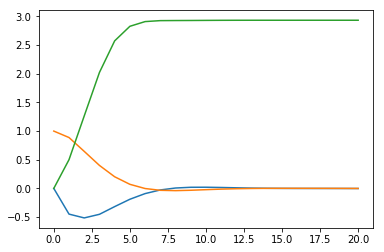

In [56]:
plot(horzcat(*sol["x",:]).T)

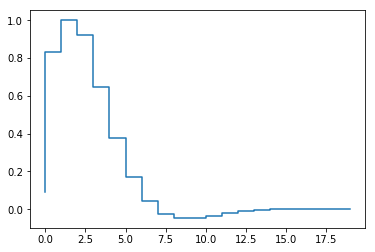

In [57]:
step(range(N),sol["u",:])

## Wrapping up

Showcase: kite-power optimization by Greg Horn, using CasADi backend

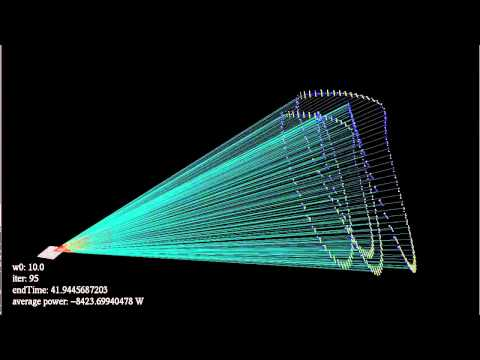

In [58]:
from IPython.display import YouTubeVideo
YouTubeVideo('tmjIBpb43j0')



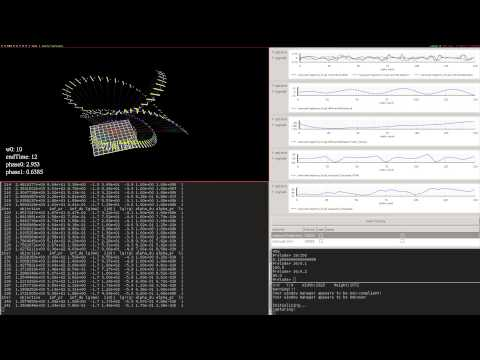

In [59]:
YouTubeVideo('SW6ZJzcMWAk')

Distinction with other software:
<table>
    <tr>
        <th>ACADOtoolkit</th><th>CasADi</th>
    </tr>
    <tr>
        <td><ul><li>Black-box solver</li><li>Standard-form OCP</li><li>Good at small-scale real-time NMPC</li><li>Easy to get started</li></ul></td>
        <td><ul><li>Write your own solver using a pool of building-blocks</li><li>No limitations on formulation</li><li>Good at large-scale OCP</li><li>Easy to extend</li></ul></td>
    </tr>
</table>

<table>
    <tr>
        <th>Other operator-overloading AD tools</th><th>CasADi</th>
    </tr>
    <tr>
        <td><ul><li>Scalar graphs only, checkpointing</li></ul></td>
        <td><ul><li>Scalar and matrix graphs</li><li>Batteries included: Ipopt, Sundials</li></ul></td>
    </tr>
</table>

Closest similarity: AMPL